In [3]:
import os
import numpy as np
import copy
import time
import matplotlib.pyplot as plt
import scipy.stats as st

%matplotlib inline
import seaborn as sns
sns.set(style="ticks")

from curbside_models import *

## Initialization

In [4]:
Q = 3 # Maximum number of spaces at each candidate location
B = 200000 # ($) budget
H = 100 # average daily pickups/dropoffs for 1 space

n_rows = 13
n_cols = 16

candidate_list = [# 0-10
                  (1, 0), (3, 0), (5, 0), (7, 0), (9, 0), (11, 0), (5, 1), (10, 1), (2, 2), (7, 2), (12, 2),
                  # 11-21
                  (0, 3), (2, 3), (4, 3), (6, 3), (8, 3), (10, 3), (12, 3), (2, 4), (7, 4), (5, 5), (10, 5),
                  # 22-35
                  (1, 6), (3, 6), (4, 6), (5, 6), (6, 6), (7, 6), (9, 6), (11, 6), (12, 6), (0, 7), (5, 7), (10, 7), (2, 8), (7, 8),
                  # 36-49
                  (2, 9), (4, 9), (5, 9), (6, 9), (7, 9), (8, 9), (10, 9), (12, 9), (2, 10), (7, 10), (12, 10), (0, 11), (5, 11), (10, 11),
                  # 50-60
                  (1, 12), (3, 12), (5, 12), (7, 12), (9, 12), (11, 12), (5, 13), (10, 13), (2, 14), (7, 14), (12, 14),
                  # 61-66
                  (0, 15), (2, 15), (4, 15), (6, 15), (8, 15), (10, 15)]
n_cand = len(candidate_list)
print(n_cand)

costs_list = [(5000, 2000) for i in range(len(candidate_list))]
srkernel_list = [[1, 0.4, 0] for i in range(len(candidate_list))]

67


## All methods

In [6]:
def obj_value(sol):
    g.clear_supply()
    for i in range(n_cand):
        if sol[i] == 1:
            g.update_supply(candidate_list[i][0], candidate_list[i][1], H)
    return g.unmet_demand()

def generate_solution(sol):
    global min_obj
    global min_cand
    if len(sol) == n_cand:
        _cost = 0
        for i in range(n_cand):
            if sol[i] > 0:
                _cost += g.cells[candidate_list[i][0]][candidate_list[i][1]].fixed_cost
                _cost += g.cells[candidate_list[i][0]][candidate_list[i][1]].operational_cost * sol[i]
        if _cost <= B and obj_value(sol) < min_obj:
            min_obj = obj_value(sol)
            min_cand = copy.copy(sol)
    else:
        sol1 = copy.copy(sol)
        sol1.append(0)
        generate_solution(sol1)
        sol2 = copy.copy(sol)
        sol2.append(1)
        generate_solution(sol2)

n = 20
obj_greedy = np.zeros(n)
time_greedy = np.zeros(n)
obj_ED = np.zeros(n)
time_ED = np.zeros(n)
obj_RS = np.zeros(n)
time_RS = np.zeros(n)
n_cand = len(candidate_list)
for seed in range(n):
    print(seed)
    np.random.seed(seed)
    demand_matrix = np.random.randint(20, size=(n_rows, n_cols))
    g = Grid(n_rows, n_cols, candidate_list, costs_list, srkernel_list, demand_matrix)
    
    # greedy
    start = time.time()
    g.clear_supply()
    budget_left = B
    min_cand2 = [0 for i in range(n_cand)]
    while budget_left > 0:
        max_contribution = 0
        _index = -1
        for i in range(n_cand):
            if min_cand2[i] < Q:
                _cost = g.cells[candidate_list[i][0]][candidate_list[i][1]].operational_cost
                if min_cand2[i] == 0:
                    _cost += g.cells[candidate_list[i][0]][candidate_list[i][1]].fixed_cost
                if _cost < budget_left:
                    _tmp = g.contribution_of_one_cadidate(candidate_list[i][0], candidate_list[i][1], H)
                    if _tmp > max_contribution:
                        max_contribution = _tmp
                        _index = i
        if _index >= 0:
            budget_left -= g.cells[candidate_list[i][0]][candidate_list[i][1]].operational_cost
            if min_cand2[_index] == 0:
                budget_left -= g.cells[candidate_list[i][0]][candidate_list[i][1]].fixed_cost
            min_cand2[_index] += 1
            g.update_supply(candidate_list[_index][0], candidate_list[_index][1], H) 
        else:
            break
    end = time.time()
    obj_greedy[seed] = g.unmet_demand()
    time_greedy[seed] = end - start
    
    # ED
    start = time.time()
    g.clear_supply()
    num = int(np.floor(B/7000))
    interval = int(np.floor(n_cand/num))
    min_cand3 = [0 for i in range(n_cand)]
    for i in range(num):
        min_cand3[i*interval] = 1
    obj_ED[seed] = obj_value(min_cand3)
    end = time.time()
    time_ED[seed] = end - start
    
    # RS
    start = time.time()
    g.clear_supply()
    min_cand4 = [0 for i in range(n_cand)]
    choice = np.random.choice(n_cand, num)
    for i in choice:
        min_cand4[i] = 1
    obj_RS[seed] = obj_value(min_cand4)
    end = time.time()
    time_RS[seed] = end - start

print('Greedy')
print(np.mean(obj_greedy), np.std(obj_greedy))
print(np.mean(time_greedy), np.std(time_greedy))
print('Evenly distributed')
print(np.mean(obj_ED), np.std(obj_ED))
print(np.mean(time_ED), np.std(time_ED))
print('Random selection')
print(np.mean(obj_RS), np.std(obj_RS))
print(np.mean(time_RS), np.std(time_RS))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
Greedy
610.2 40.2648730285
0.0808357834816 0.0101759216692
Evenly distributed
901.05 47.0887194559
0.00160100460052 0.000861120037518
Random selection
1116.45 54.1391494207
0.00149943828583 0.00107212556948


## Low variance case

In [125]:
np.random.seed(101)
demand_matrix2 = np.random.randint(20, 25, size=(n_rows, n_cols))

for i in range(n_rows):
    for j in range(n_cols):
        if i >= 3 and i <= 10 and j >= 3 and j <= 12:
            demand_matrix2[i,j] = np.random.randint(25, 35, size=1)[0]
        if i >= 5 and i <= 7 and j >= 6 and j <= 9:
            demand_matrix2[i,j] = np.random.randint(30, 40, size=1)[0]
            
demand_matrix2 = demand_matrix2 - 5
print(np.sum(demand_matrix2))

g2 = Grid(n_rows, n_cols, candidate_list, costs_list, srkernel_list, demand_matrix2)

4235


In [124]:
start = time.time()

g2.clear_supply()
budget_left = B
min_cand2 = [0 for i in range(n_cand)]

while budget_left > 0:
    max_contribution = 0
    _index = -1
    for i in range(n_cand):
        if min_cand2[i] < Q:
            _cost = g2.cells[candidate_list[i][0]][candidate_list[i][1]].operational_cost
            if min_cand2[i] == 0:
                _cost += g2.cells[candidate_list[i][0]][candidate_list[i][1]].fixed_cost
            if _cost < budget_left:
                _tmp = g2.contribution_of_one_cadidate(candidate_list[i][0], candidate_list[i][1], H)
                if _tmp > max_contribution:
                    max_contribution = _tmp
                    _index = i
    if _index >= 0:
        budget_left -= g2.cells[candidate_list[i][0]][candidate_list[i][1]].operational_cost
        if min_cand2[_index] == 0:
            budget_left -= g2.cells[candidate_list[i][0]][candidate_list[i][1]].fixed_cost
        min_cand2[_index] += 1
        g2.update_supply(candidate_list[_index][0], candidate_list[_index][1], H) 
    else:
        break

print(g2.unmet_demand())
print(min_cand2)
print(sum(min_cand2))
print(sum(map(lambda x: 1 if x else 0, min_cand2)))

end = time.time()
print(end - start)

# # 0-10
print((1, 0), (3, 0), (5, 0), (7, 0), (9, 0), (11, 0), (5, 1), (10, 1), (2, 2), (7, 2), (12, 2))
print(min_cand2[:11])
# # 11-21
print((0, 3), (2, 3), (4, 3), (6, 3), (8, 3), (10, 3), (12, 3), (2, 4), (7, 4), (5, 5), (10, 5))
print(min_cand2[11:22])
# # 22-35
print((1, 6), (3, 6), (4, 6), (5, 6), (6, 6), (7, 6), (9, 6), (11, 6), (12, 6), (0, 7), (5, 7), (10, 7), (2, 8), (7, 8))
print(min_cand2[22:36])
# # 36-49
print((2, 9), (4, 9), (5, 9), (6, 9), (7, 9), (8, 9), (10, 9), (12, 9), (2, 10), (7, 10), (12, 10), (0, 11), (5, 11), (10, 11))
print(min_cand2[36:50])
# # 50-60
print((1, 12), (3, 12), (5, 12), (7, 12), (9, 12), (11, 12), (5, 13), (10, 13), (2, 14), (7, 14), (12, 14))
print(min_cand2[50:61])
# # 61-66
print((0, 15), (2, 15), (4, 15), (6, 15), (8, 15), (10, 15))
print(min_cand2[61:])

2052.8
[1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 2, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0]
29
28
0.05597329139709473
(1, 0) (3, 0) (5, 0) (7, 0) (9, 0) (11, 0) (5, 1) (10, 1) (2, 2) (7, 2) (12, 2)
[1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1]
(0, 3) (2, 3) (4, 3) (6, 3) (8, 3) (10, 3) (12, 3) (2, 4) (7, 4) (5, 5) (10, 5)
[0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0]
(1, 6) (3, 6) (4, 6) (5, 6) (6, 6) (7, 6) (9, 6) (11, 6) (12, 6) (0, 7) (5, 7) (10, 7) (2, 8) (7, 8)
[0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0]
(2, 9) (4, 9) (5, 9) (6, 9) (7, 9) (8, 9) (10, 9) (12, 9) (2, 10) (7, 10) (12, 10) (0, 11) (5, 11) (10, 11)
[0, 0, 1, 0, 2, 0, 1, 0, 1, 0, 0, 0, 1, 0]
(1, 12) (3, 12) (5, 12) (7, 12) (9, 12) (11, 12) (5, 13) (10, 13) (2, 14) (7, 14) (12, 14)
[0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1]
(0, 15) (2, 15) (4, 15) (6, 15) (8, 15) (10, 15)
[0, 0, 1, 0, 0, 0]


## High variance case

In [93]:
np.random.seed(102)
demand_matrix = np.random.randint(5, 20, size=(n_rows, n_cols))

for i in range(n_rows):
    for j in range(n_cols):
        if i >= 3 and i <= 10 and j >= 3 and j <= 12:
            demand_matrix[i,j] = np.random.randint(15, 40, size=1)[0]
        if i >= 5 and i <= 7 and j >= 6 and j <= 9:
            demand_matrix[i,j] = np.random.randint(50, 100, size=1)[0]
            
print(np.sum(demand_matrix))

g = Grid(n_rows, n_cols, candidate_list, costs_list, srkernel_list, demand_matrix)

4312


In [94]:
start = time.time()

g.clear_supply()
budget_left = B
min_cand = [0 for i in range(n_cand)]

while budget_left > 0:
    max_contribution = 0
    _index = -1
    for i in range(n_cand):
        if min_cand[i] < Q:
            _cost = g.cells[candidate_list[i][0]][candidate_list[i][1]].operational_cost
            if min_cand[i] == 0:
                _cost += g.cells[candidate_list[i][0]][candidate_list[i][1]].fixed_cost
            if _cost < budget_left:
                _tmp = g.contribution_of_one_cadidate(candidate_list[i][0], candidate_list[i][1], H)
                if _tmp > max_contribution:
                    max_contribution = _tmp
                    _index = i
    if _index >= 0:
        budget_left -= g.cells[candidate_list[i][0]][candidate_list[i][1]].operational_cost
        if min_cand[_index] == 0:
            budget_left -= g.cells[candidate_list[i][0]][candidate_list[i][1]].fixed_cost
        min_cand[_index] += 1
        g.update_supply(candidate_list[_index][0], candidate_list[_index][1], H) 
    else:
        break

print(g.unmet_demand())
print(min_cand)
print(sum(min_cand))
print(sum(map(lambda x: 1 if x else 0, min_cand)))

end = time.time()
print(end - start)

# # 0-10
print((1, 0), (3, 0), (5, 0), (7, 0), (9, 0), (11, 0), (5, 1), (10, 1), (2, 2), (7, 2), (12, 2))
print(min_cand[:11])
# # 11-21
print((0, 3), (2, 3), (4, 3), (6, 3), (8, 3), (10, 3), (12, 3), (2, 4), (7, 4), (5, 5), (10, 5))
print(min_cand[11:22])
# # 22-35
print((1, 6), (3, 6), (4, 6), (5, 6), (6, 6), (7, 6), (9, 6), (11, 6), (12, 6), (0, 7), (5, 7), (10, 7), (2, 8), (7, 8))
print(min_cand[22:36])
# # 36-49
print((2, 9), (4, 9), (5, 9), (6, 9), (7, 9), (8, 9), (10, 9), (12, 9), (2, 10), (7, 10), (12, 10), (0, 11), (5, 11), (10, 11))
print(min_cand[36:50])
# # 50-60
print((1, 12), (3, 12), (5, 12), (7, 12), (9, 12), (11, 12), (5, 13), (10, 13), (2, 14), (7, 14), (12, 14))
print(min_cand[50:61])
# # 61-66
print((0, 15), (2, 15), (4, 15), (6, 15), (8, 15), (10, 15))
print(min_cand[61:])

1738.0
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 2, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 3, 1, 1, 2, 0, 1, 2, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
32
27
0.07240915298461914
(1, 0) (3, 0) (5, 0) (7, 0) (9, 0) (11, 0) (5, 1) (10, 1) (2, 2) (7, 2) (12, 2)
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
(0, 3) (2, 3) (4, 3) (6, 3) (8, 3) (10, 3) (12, 3) (2, 4) (7, 4) (5, 5) (10, 5)
[0, 0, 1, 1, 0, 2, 0, 1, 1, 0, 0]
(1, 6) (3, 6) (4, 6) (5, 6) (6, 6) (7, 6) (9, 6) (11, 6) (12, 6) (0, 7) (5, 7) (10, 7) (2, 8) (7, 8)
[0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 3, 1, 1, 2]
(2, 9) (4, 9) (5, 9) (6, 9) (7, 9) (8, 9) (10, 9) (12, 9) (2, 10) (7, 10) (12, 10) (0, 11) (5, 11) (10, 11)
[0, 1, 2, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1]
(1, 12) (3, 12) (5, 12) (7, 12) (9, 12) (11, 12) (5, 13) (10, 13) (2, 14) (7, 14) (12, 14)
[0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0]
(0, 15) (2, 15) (4, 15) (6, 15) (8, 15) (10, 15)
[0, 0, 0, 0, 0, 0]


## Visualization of demand

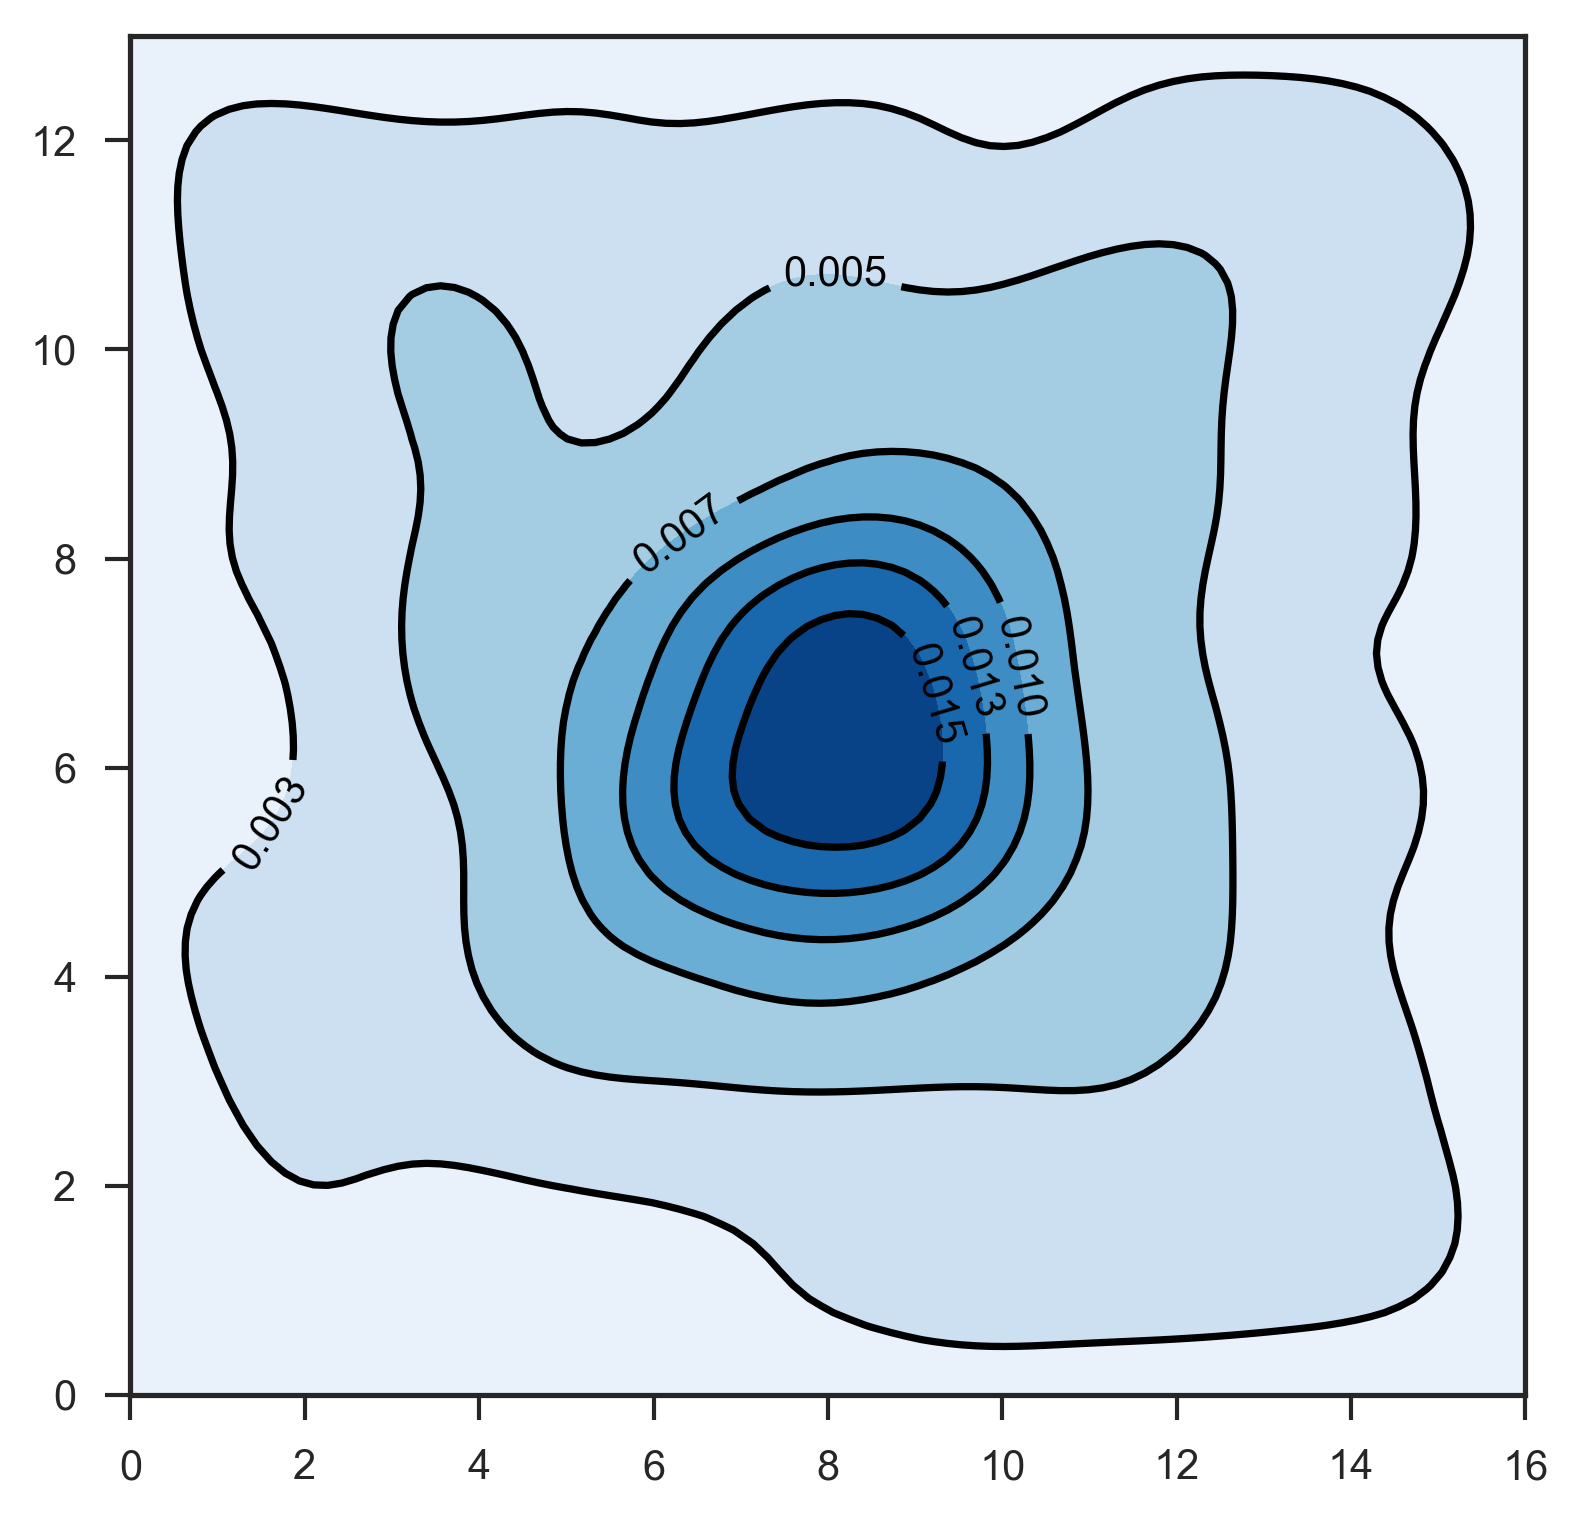

In [112]:
_x = np.zeros(0)
_y = np.zeros(0)
for i in range(n_rows):
    for j in range(n_cols):
        _tmpx = np.random.uniform(i, i+1, demand_matrix[i,j])
        _tmpy = np.random.uniform(j, j+1, demand_matrix[i,j])
        _x = np.concatenate((_x, _tmpx))
        _y = np.concatenate((_y, _tmpy))
x = np.array(_y)
y = np.array(_x)

ymin, ymax = 0, 13
xmin, xmax = 0, 16

# Peform the kernel density estimate
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = st.gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)

fig = plt.figure(figsize=(6, 6), dpi=300)
ax = fig.gca()
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
# Contourf plot
cfset = ax.contourf(xx, yy, f, cmap='Blues')
## Or kernel density estimate plot instead of the contourf plot
#ax.imshow(np.rot90(f), cmap='Blues', extent=[xmin, xmax, ymin, ymax])
# Contour plot
cset = ax.contour(xx, yy, f, colors='k')
# Label plot
ax.clabel(cset, inline=1, fontsize=10)
# ax.set_xlabel('Y1')
# ax.set_ylabel('Y0')

plt.show()

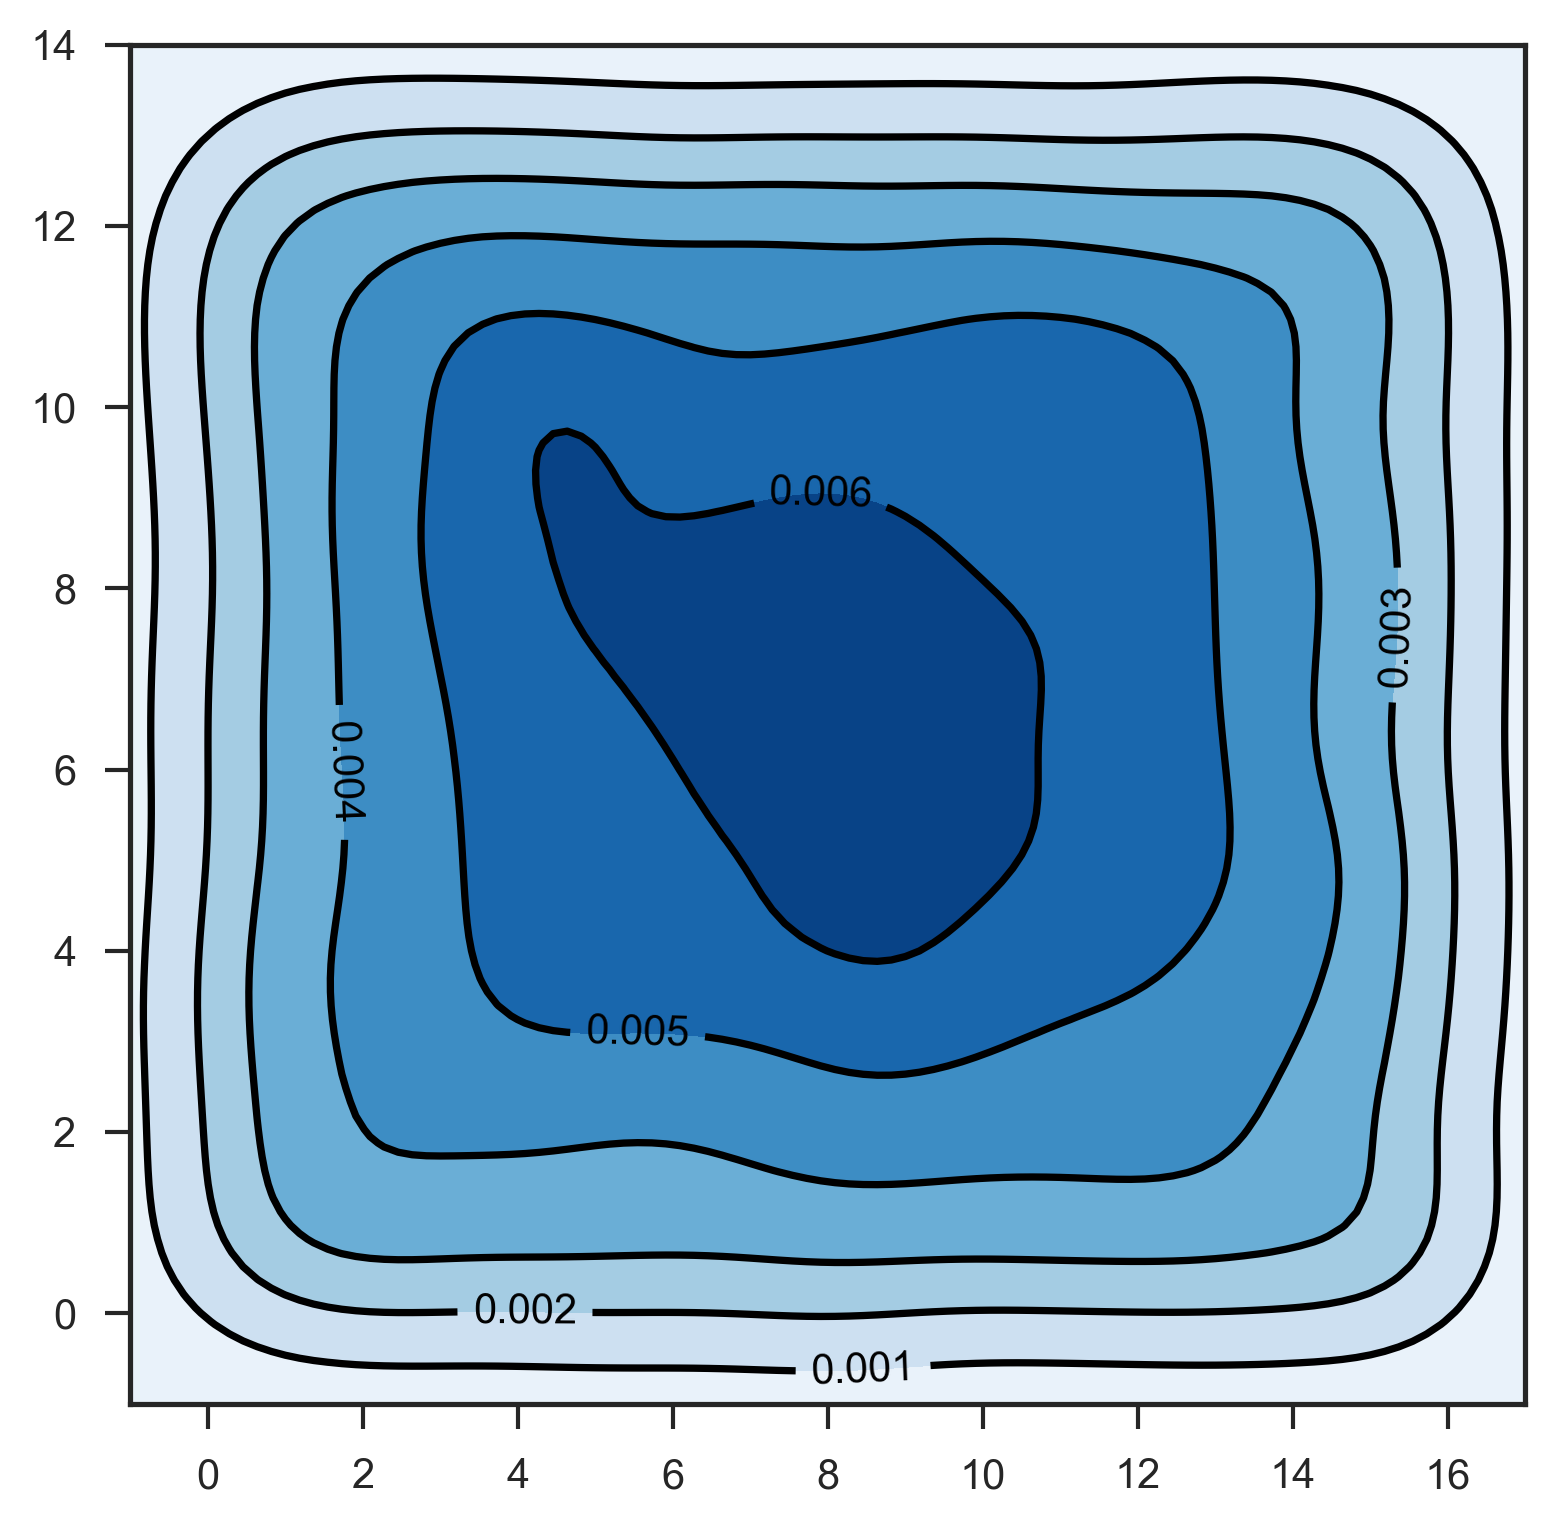

In [126]:
_x = np.zeros(0)
_y = np.zeros(0)
for i in range(n_rows):
    for j in range(n_cols):
        _tmpx = np.random.uniform(i, i+1, demand_matrix2[i,j])
        _tmpy = np.random.uniform(j, j+1, demand_matrix2[i,j])
        _x = np.concatenate((_x, _tmpx))
        _y = np.concatenate((_y, _tmpy))
x = np.array(_y)
y = np.array(_x)

ymin, ymax = -1, 14
xmin, xmax = -1, 17

# Peform the kernel density estimate
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = st.gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)

fig = plt.figure(figsize=(6, 6), dpi=300)
ax = fig.gca()
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
# Contourf plot
cfset = ax.contourf(xx, yy, f, cmap='Blues')
## Or kernel density estimate plot instead of the contourf plot
#ax.imshow(np.rot90(f), cmap='Blues', extent=[xmin, xmax, ymin, ymax])
# Contour plot
cset = ax.contour(xx, yy, f, colors='k')
# Label plot
ax.clabel(cset, inline=1, fontsize=10)
# ax.set_xlabel('Y1')
# ax.set_ylabel('Y0')

plt.show()

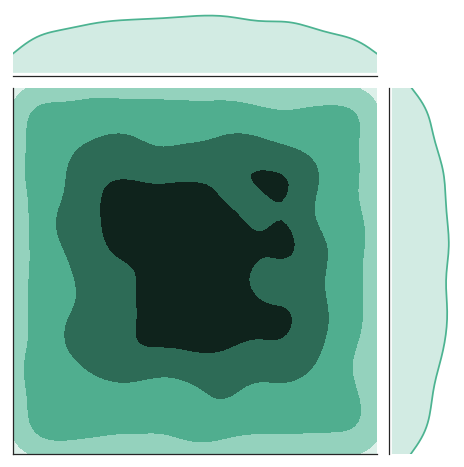

In [95]:
x2 = np.zeros(0)
y2 = np.zeros(0)
for i in range(n_rows):
    for j in range(n_cols):
        _tmpx = np.random.uniform(i, i+1, demand_matrix2[i,j])
        _tmpy = np.random.uniform(j, j+1, demand_matrix2[i,j])
        x2 = np.concatenate((x2, _tmpx))
        y2 = np.concatenate((y2, _tmpy))

grid = sns.jointplot(y2, x2, kind="kde", color="#4CB391", n_levels = 4, ylim=[0,13], xlim=[0,16])
grid.ax_joint.legend_.remove()
# grid.ax_marg_x.set_axis_off()
# grid.ax_marg_y.set_axis_off()
grid.ax_joint.set_xticks([])
grid.ax_joint.set_yticks([])
grid.fig.set_figwidth(7)
grid.fig.set_figheight(7)
# grid.savefig("kde_low.png", dpi=300)

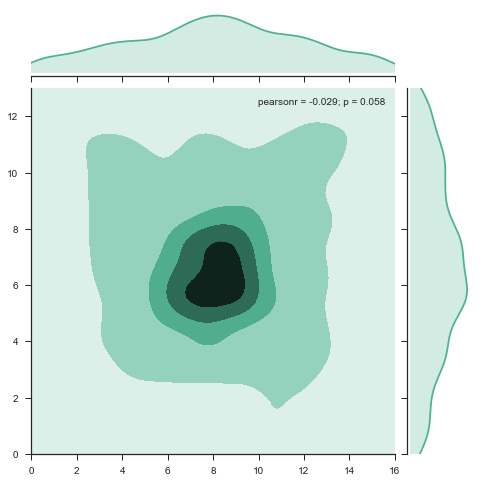

In [103]:
x = np.zeros(0)
y = np.zeros(0)
for i in range(n_rows):
    for j in range(n_cols):
        _tmpx = np.random.uniform(i, i+1, demand_matrix[i,j])
        _tmpy = np.random.uniform(j, j+1, demand_matrix[i,j])
        x = np.concatenate((x, _tmpx))
        y = np.concatenate((y, _tmpy))
x = np.array(x)
y = np.array(y)

grid = sns.jointplot(y, x, kind="kde", color="#4CB391", n_levels = 5, ylim=[0,13], xlim=[0,16], cbar=True)
# grid.ax_joint.legend_.remove()
# grid.ax_marg_x.set_axis_off()
# grid.ax_marg_y.set_axis_off()
# grid.ax_joint.set_xticks([])
# grid.ax_joint.set_yticks([])
grid.fig.set_figwidth(7)
grid.fig.set_figheight(7)
# grid.savefig("kde_high.png", dpi=300)

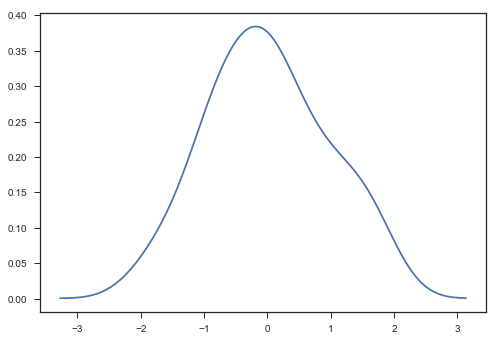

In [14]:
mean, cov = [0, 2], [(1, .5), (.5, 1)]
x, y = np.random.multivariate_normal(mean, cov, size=50).T
ax = sns.kdeplot(x)
# plt.savefig("kde_test.png", dpi=300)
plt.show()

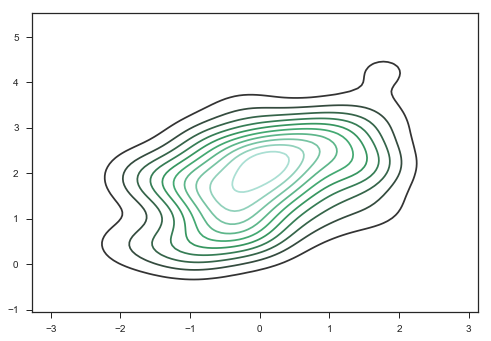

In [16]:
ax = sns.kdeplot(x, y, cbar=False)
# plt.savefig("kde_test.png", dpi=300)
plt.show()